In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math

2023-03-04 14:38:52.513911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 14:38:52.607988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 14:38:52.608008: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-04 14:38:53.327146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

2023-03-04 14:38:54.024442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 14:38:54.042357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 14:38:54.042443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 14:38:54.042483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5986424407592339807
 xla_global_id: -1]

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

In [4]:
if 1:
    !pip install scikit-image
from skimage.transform import rescale, resize


if 1:
    !wget http://www.csc.kth.se/cvap/actions/walking.zip
    !wget http://www.csc.kth.se/cvap/actions/jogging.zip
    !wget http://www.csc.kth.se/cvap/actions/running.zip
    !wget http://www.csc.kth.se/cvap/actions/boxing.zip
    !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
    !wget http://www.csc.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

In [5]:
 classes = {
    'walking': 0,
    'jogging': 1,
    'running': 2,
    'boxing': 3,
    'handwaving': 4,
    'handclapping': 5,
 }    

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        dataset.append(fpath)

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
SUBSET_LEN = 200
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]
batch_size = 8
train, test = train_test_split(dataset, test_size=0.20, random_state=42)
#train, validate = train_test_split(train, test_size=0.20, random_state=42)
print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 200


In [7]:
print(len(train))
#print(len(validate))
print(len(test))

160
40


In [8]:
# path приходит как тензор
# .numpy() - выделяет содержимое в байтовом формате
# .decode() преобразует в строку
def read_video(path):
    path = (path.numpy()).decode()
    video = skvideo.io.vread(path)
    video = video.astype(np.float32) / 255.

    # приводим тензоры (видео) к единому размеру (для формирования батча)
    video = resize(video, (300, 120, 160, 1), anti_aliasing=True)


    # motion реализован здесь (на кадре будут только изменения пикселов 
    # между соседними кадрами отображаться)
    video = np.mean(video[1:, ...] - video[:-1, ...], axis=3, keepdims=True)

    video_class = classes[path.split('/')[1]]
    return video, video_class

def item_to_video(item):
    video, video_class = tf.py_function(read_video, [item], [tf.float32, tf.uint8])
    return video, video_class

In [9]:
test_ds = tf.data.Dataset.from_tensor_slices(test)
test_ds = test_ds.shuffle(buffer_size=len(test))
test_ds = test_ds.map(item_to_video)
test_ds = test_ds.batch(batch_size, drop_remainder=True)

2023-03-04 14:39:01.124060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 14:39:01.124112: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(buffer_size=len(train))
train_ds = train_ds.map(item_to_video)
train_ds = train_ds.batch(batch_size, drop_remainder=True)

In [11]:
iterator = iter(train_ds)

In [12]:
sample = next(iterator)

Class: ['handclapping']
Videodata shape: (299, 120, 160, 1)


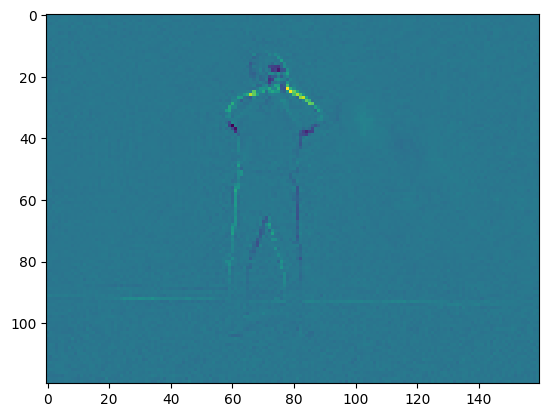

In [13]:
# С использованием батча (train_ds.batch(batch_size, drop_remainder=True))
# sample[0][0][50, ...]
# 1-й ноль - контейнер с видео (измерение батча)
# 2-й ноль - само видео
# 50 - номер кадра

plt.imshow(sample[0][0][90, ..., 0])
print(f"Class: {[name for name, num in classes.items() if num == sample[1][0].numpy()]}")
print('Videodata shape:', sample[0][0].shape)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (2, 2, 2), padding='same', kernel_initializer = 'he_normal', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (2, 2, 2), padding='same', kernel_initializer = 'he_normal', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (2, 2, 2), padding='same', kernel_initializer = 'he_normal', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', kernel_initializer = 'he_normal', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(6, activation=None),
])

In [16]:
#vid = sample[0][None, ...] # Если без использования батча
vid = sample[0]
out = model(vid)
y = sample[1]
print('Input shape:', vid.shape)
print('Output shape:', out.shape)
print('Target:', y.numpy())
print('Predicted target:', np.argmax(out, axis=1))

Input shape: (8, 299, 120, 160, 1)
Output shape: (8, 6)
Target: [5 0 1 2 3 2 4 1]
Predicted target: [0 0 1 0 1 0 1 1]


In [17]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.002
loss_f = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    loss=loss_f, 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [18]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, batch in enumerate(train_ds):

        # Батч-измерения прикручиваем, если в train_ds батч не задан
        #x = batch[0][None, ...]
        #y = batch[1][None, ...]

        # Если же батч задан, то добавлять измерения не нужно
        x = batch[0]
        y = batch[1]

        loss_value = model.train_on_batch(x, y)

        if iter % 2 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{math.ceil(len(train)/batch_size)}] Loss = {loss_value}')

        with writer.as_default():
            tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1
    
    val_loss = 0
    val_accuracy = 0
    for iter, batch in enumerate(test_ds):

        #x = batch[0][None, ...]
        #y = batch[1][None, ...]
        x = batch[0]
        y = batch[1]

        y_pred = model(x)
        val_loss += loss_f(y, y_pred)
        val_accuracy += np.sum(np.argmax(y_pred, axis=1) == y)/batch_size
    print(f"Epoch № {ep}: Val loss = {val_loss/iter}, Accuracy = {val_accuracy/iter}")

[0/10][0/20] Loss = 1.5709011554718018
[0/10][2/20] Loss = 2.4475555419921875
[0/10][4/20] Loss = 1.4604946374893188
[0/10][6/20] Loss = 1.7265691757202148
[0/10][8/20] Loss = 1.3833942413330078
[0/10][10/20] Loss = 1.4258472919464111
[0/10][12/20] Loss = 1.37118661403656
[0/10][14/20] Loss = 1.581765055656433
[0/10][16/20] Loss = 1.2449419498443604
[0/10][18/20] Loss = 1.5134060382843018
Epoch № 0: Val loss = 3.517010450363159, Accuracy = 0.15625
[1/10][0/20] Loss = 1.1732689142227173
[1/10][2/20] Loss = 0.9782186150550842
[1/10][4/20] Loss = 0.7518054246902466
[1/10][6/20] Loss = 1.6375805139541626
[1/10][8/20] Loss = 0.7904829382896423
[1/10][10/20] Loss = 0.901155412197113
[1/10][12/20] Loss = 0.5567685961723328
[1/10][14/20] Loss = 0.6553055644035339
[1/10][16/20] Loss = 0.7652838230133057
[1/10][18/20] Loss = 0.6255566477775574
Epoch № 1: Val loss = 4.579699993133545, Accuracy = 0.1875
[2/10][0/20] Loss = 0.6232941150665283
[2/10][2/20] Loss = 0.730884850025177
[2/10][4/20] Loss 

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs

In [20]:
val_loss = 0
val_accuracy = 0
for iter, batch in enumerate(test_ds):

    x = batch[0]
    y = batch[1]

    y_pred = model(x)
    val_loss += loss_f(y, y_pred)
    val_accuracy += np.sum(np.argmax(y_pred, axis=1) == y)/batch_size

print(f"Val loss = {val_loss/iter}, Accuracy = {val_accuracy/iter}")

Val loss = 2.913106679916382, Accuracy = 0.4375


True class: ['jogging']
Predicted class: ['jogging']


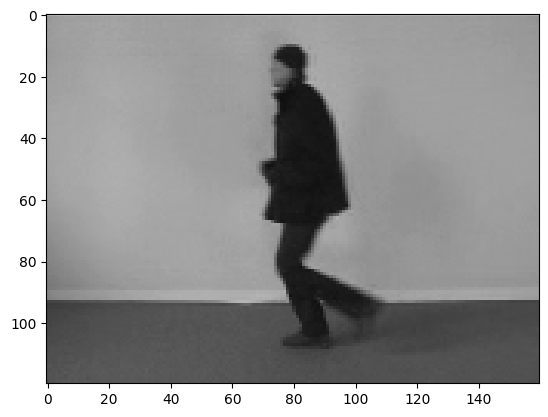

In [21]:
fpath = random.choice(dataset)
video_class = classes[fpath.split('/')[1]]

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', [name for name, num in classes.items() if num == video_class])
print('Predicted class:', [name for name, num in classes.items() if num == cls_pred])